Number of classes: 15
Found 4122 images belonging to 15 classes.
129/129 [==============================] - 61s 466ms/step


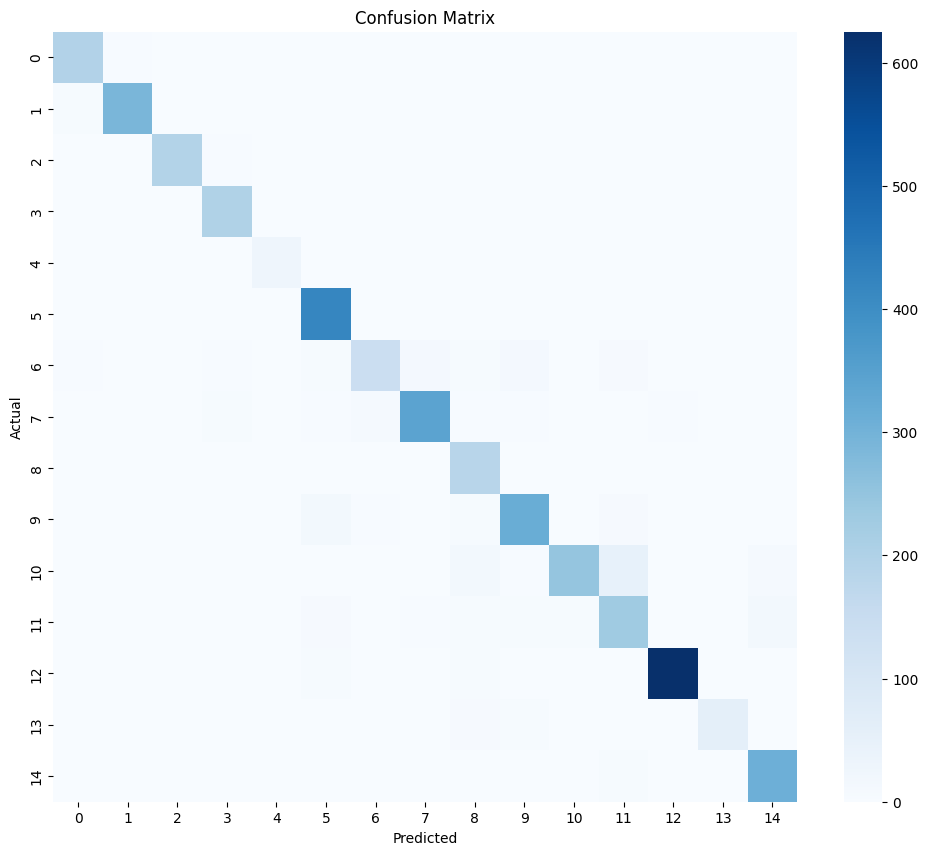

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.90      0.98      0.94       199
                     Pepper__bell___healthy       0.99      0.98      0.98       295
                      Potato___Early_blight       0.99      0.96      0.98       200
                       Potato___Late_blight       0.92      0.99      0.95       200
                           Potato___healthy       1.00      0.93      0.97        30
                      Tomato_Bacterial_spot       0.91      0.98      0.94       425
                        Tomato_Early_blight       0.88      0.70      0.78       200
                         Tomato_Late_blight       0.94      0.90      0.92       381
                           Tomato_Leaf_Mold       0.79      0.97      0.87       190
                  Tomato_Septoria_leaf_spot       0.89      0.89      0.89       354
Tomato_Spider_mites_Two_spotted_spider_mite       0.94      0.74

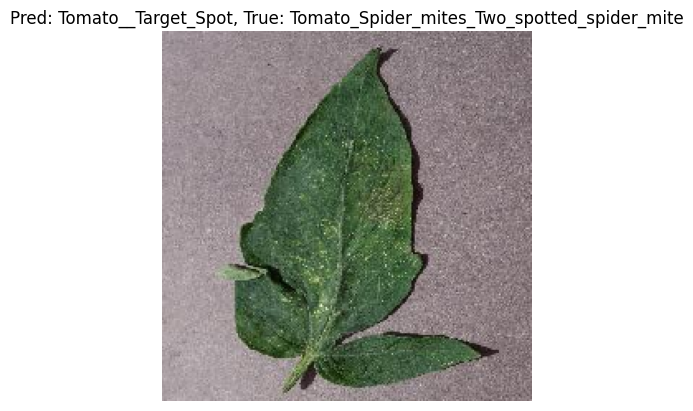

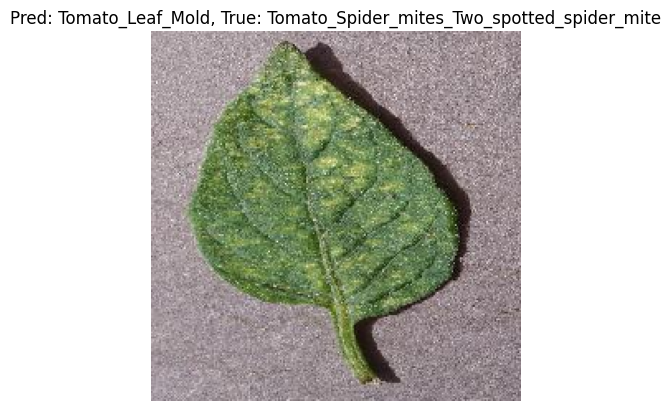

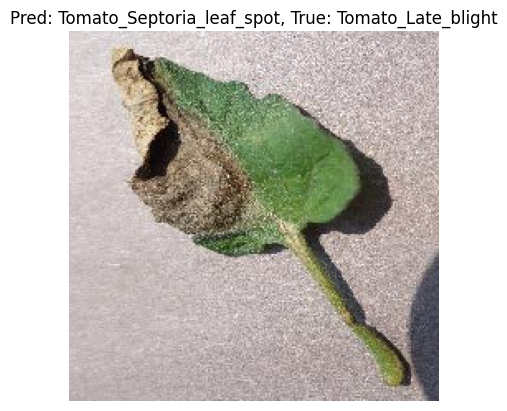

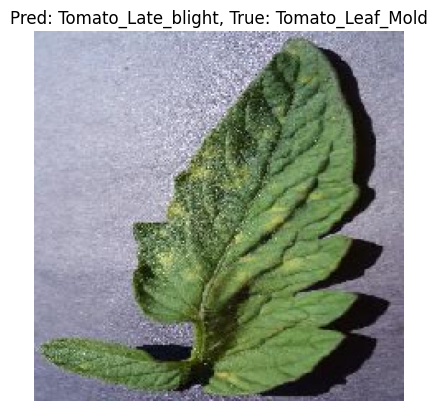

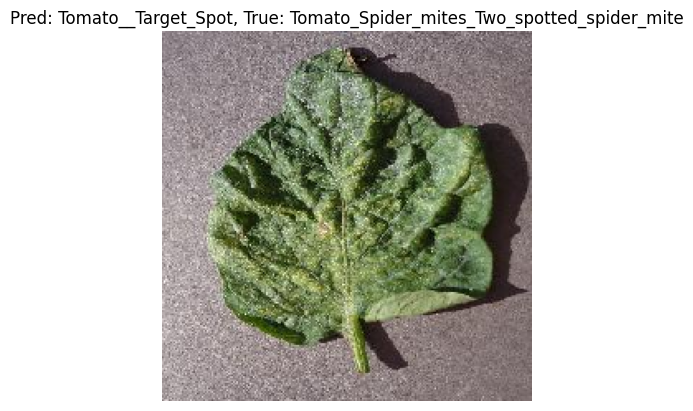

In [1]:
# 04_model_evaluation.ipynb

import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
MODEL_PATH = "../models/crop_disease_cnn.h5"
LABEL_PATH = "../models/label_encoder.pkl"
DATA_DIR = "../data/raw/PlantVillage"
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# ========================
# Step 1: Load model & classes
# ========================
model = load_model(MODEL_PATH)

with open(LABEL_PATH, "rb") as f:
    class_indices = pickle.load(f)

# Invert class_indices to map indices to class names
idx_to_class = {v:k for k,v in class_indices.items()}

num_classes = len(class_indices)
print("Number of classes:", num_classes)

# ========================
# Step 2: Validation Generator
# ========================
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ========================
# Step 3: Predictions
# ========================
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# ========================
# Step 4: Confusion Matrix
# ========================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ========================
# Step 5: Classification Report
# ========================
report = classification_report(y_true, y_pred, target_names=list(class_indices.keys()))
print(report)

# ========================
# Step 6: Show some misclassified images
# ========================
import random
from tensorflow.keras.preprocessing import image

errors = np.where(y_pred != y_true)[0]
print(f"Total misclassified: {len(errors)}")

for i in random.sample(list(errors), min(5, len(errors))):
    img_path = validation_generator.filepaths[i]
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    plt.imshow(img)
    plt.title(f"Pred: {idx_to_class[y_pred[i]]}, True: {idx_to_class[y_true[i]]}")
    plt.axis("off")
    plt.show()
